In [1]:
dir = '/Users/jngelena/Desktop/computer_vision/project' 
emo_data_dir = dir + '/emotion_dataset'
type_data_dir = dir + '/animal_human_dataset'

RANDOM_SEED = 42

In [2]:
#import useful package
import os
import shutil
import cv2
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

/Users/jngelena/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model, save_model


In [4]:
"""
This function generate a dictionary with path of an image and its label.
"""
def generate_data_paths(data_dir):    
    image_path_label = {}
    folds = os.listdir(data_dir)

    for fold in folds:
        if fold.startswith('.') or not os.path.isdir(os.path.join(data_dir, fold)):
            continue
            
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            image_path_label[fpath] = fold
            
    return image_path_label

In [5]:
"""
This function tells how many images contain in each folder.
"""
def classes_count(df, name= 'dataset'):
    print(f"The {name} has: ")
    for name in df['label'].unique():
        num_class = len(df['label'][df['label'] == name])
        print(f"Class '{name}' has {num_class} images")

In [6]:
image_path_label = generate_data_paths(type_data_dir)
df_type = pd.DataFrame(list(image_path_label.items()), columns=['path', 'label'])
display(df_type)

,path,label
0,/Users/jngelena/Desktop/computer_vision/projec...,animal
1,/Users/jngelena/Desktop/computer_vision/projec...,animal
2,/Users/jngelena/Desktop/computer_vision/projec...,animal
3,/Users/jngelena/Desktop/computer_vision/projec...,animal
4,/Users/jngelena/Desktop/computer_vision/projec...,animal
...,...,...
2025,/Users/jngelena/Desktop/computer_vision/projec...,human
2026,/Users/jngelena/Desktop/computer_vision/projec...,human
2027,/Users/jngelena/Desktop/computer_vision/projec...,human
2028,/Users/jngelena/Desktop/computer_vision/projec...,human


In [7]:
print(f"The Human and Animal dataset has {df_type.shape[0]} images divided in {len(df_type['label'].unique())} classes")

The Human and Animal dataset has 2030 images divided in 2 classes


In [8]:
classes_count(df_type, name='Human and Animal dataset')

The Human and Animal dataset has: 
Class 'animal' has 1001 images
Class 'human' has 1029 images


In [9]:
def split_dataframe(df):
    train_df, dummy_df = train_test_split(df, train_size= 0.7, shuffle= True, random_state= RANDOM_SEED)
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.6, shuffle= True, random_state= RANDOM_SEED)
    return train_df, valid_df, test_df

In [10]:
train_df_type, valid_df_type, test_df_type = split_dataframe(df_type)

In [11]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

In [12]:
num_of_examples(train_df_type, 'Human and Animal Training')
num_of_examples(valid_df_type, 'Human and Animal Validation')
num_of_examples(test_df_type, 'Human and Animal Testing')

The Human and Animal Training dataset has 1421 images.
The Human and Animal Validation dataset has 365 images.
The Human and Animal Testing dataset has 244 images.


In [13]:
classes_count(train_df_type, 'training dataset')

The training dataset has: 
Class 'human' has 725 images
Class 'animal' has 696 images


In [14]:
def plot_generator_images(data_generator, num_images=4):


    g_dict = data_generator.class_indices      # defines dictionary {'class': index}
    classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(data_generator)  
    
    plt.figure(figsize=(12, 12))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, fontsize= 12)
        plt.axis('off')
    
    plt.show()    # get a batch size samples from the generator

In [15]:
def create_and_plot_data_generators(train_df, valid_df, test_df, batch_size=16, img_size=(224, 224), channels=3):
    # Calculate a recommended test batch size based on the length of the test dataset
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

    # Define a function for data augmentation that takes an image and returns it unchanged
    def scalar(img):
        return img

    # Create ImageDataGenerator objects for training, validation, and testing with data augmentation settings
    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.4, 0.6],
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True
    )

    ts_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.4, 0.6],
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True
    )

    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='path',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    valid_gen = ts_gen.flow_from_dataframe(
        valid_df,
        x_col='path',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    # Note: we will use a custom test_batch_size, and make shuffle=False
    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='path',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,
        batch_size=test_batch_size
    )

    # Plot images from the training generator
    print("Training Generator:")
    plot_generator_images(train_gen)

    # Plot images from the validation generator
    print("Validation Generator:")
    plot_generator_images(valid_gen)

    # Plot images from the test generator
    print("Test Generator:")
    plot_generator_images(test_gen)

    return train_gen, valid_gen, test_gen


Found 1419 validated image filenames belonging to 2 classes.
Found 365 validated image filenames belonging to 2 classes.
Found 244 validated image filenames belonging to 2 classes.


Training Generator:


/Users/jngelena/Library/Python/3.9/lib/python/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


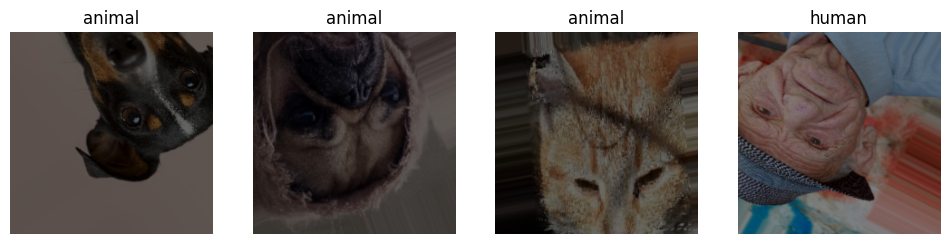

Validation Generator:


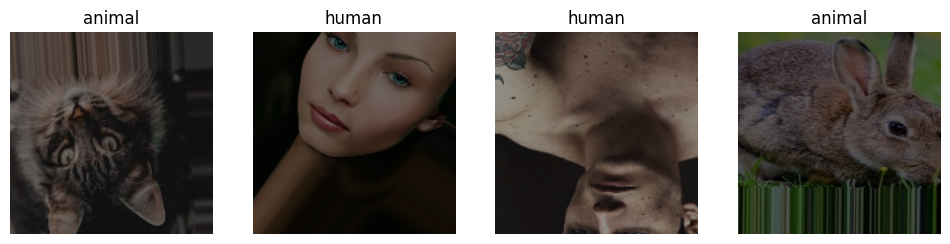

Test Generator:


/Users/jngelena/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


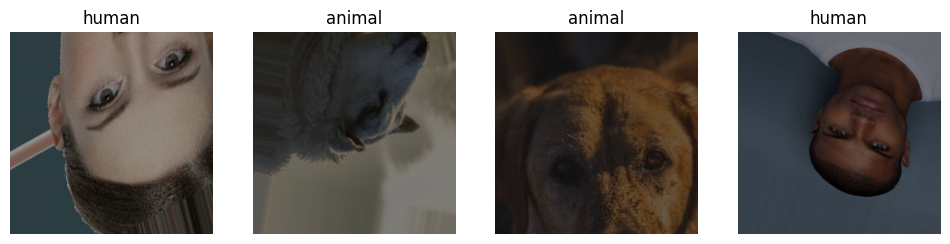

In [16]:
train_gen_type, valid_gen_type, test_gen_type = create_and_plot_data_generators(train_df_type, valid_df_type, test_df_type)

In [17]:
def create_efficientnet_model(img_size=(224, 224), channels=3, class_count=10):
    # Input shape
    img_shape = (img_size[0], img_size[1], channels)

    # Create pre-trained model (EfficientNetB5 in this case)
    base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
    base_model.trainable = False

    # Build the model
    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(256, activation='relu'),
        Dense(128, kernel_regularizer= regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu'),
        Dropout(rate=0.45, seed=RANDOM_SEED),
        Dense(class_count, activation='softmax')
    ])
    model.summary()

    # Set the training parameters
    model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

    return model

In [18]:
class_count_type = len(list(train_gen_type.class_indices.keys()))
model_type = create_efficientnet_model(class_count=class_count_type)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2

In [19]:
batch_size = 16   # set batch size for training
history_type = model_type.fit(x=train_gen_type,
                    epochs= 10,
                    verbose= 1,
                    validation_data= valid_gen_type, 
                    validation_steps= None,
                    shuffle= False)

Epoch 1/10
89/89 [==============================] - 74s 766ms/step - loss: 3.2098 - accuracy: 0.8513 - val_loss: 2.9341 - val_accuracy: 0.9479
Epoch 2/10
89/89 [==============================] - 67s 749ms/step - loss: 2.7099 - accuracy: 0.9507 - val_loss: 2.4465 - val_accuracy: 0.9890
Epoch 3/10
89/89 [==============================] - 71s 793ms/step - loss: 2.3247 - accuracy: 0.9753 - val_loss: 2.0851 - val_accuracy: 1.0000
Epoch 4/10
89/89 [==============================] - 71s 799ms/step - loss: 2.0139 - accuracy: 0.9683 - val_loss: 1.7956 - val_accuracy: 0.9945
Epoch 5/10
89/89 [==============================] - 70s 787ms/step - loss: 1.7160 - accuracy: 0.9803 - val_loss: 1.5234 - val_accuracy: 0.9945
Epoch 6/10
89/89 [==============================] - 71s 797ms/step - loss: 1.4586 - accuracy: 0.9746 - val_loss: 1.2872 - val_accuracy: 1.0000
Epoch 7/10
89/89 [==============================] - 72s 805ms/step - loss: 1.2325 - accuracy: 0.9796 - val_loss: 1.0823 - val_accuracy: 0.9973

In [20]:
def plot_training_history(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

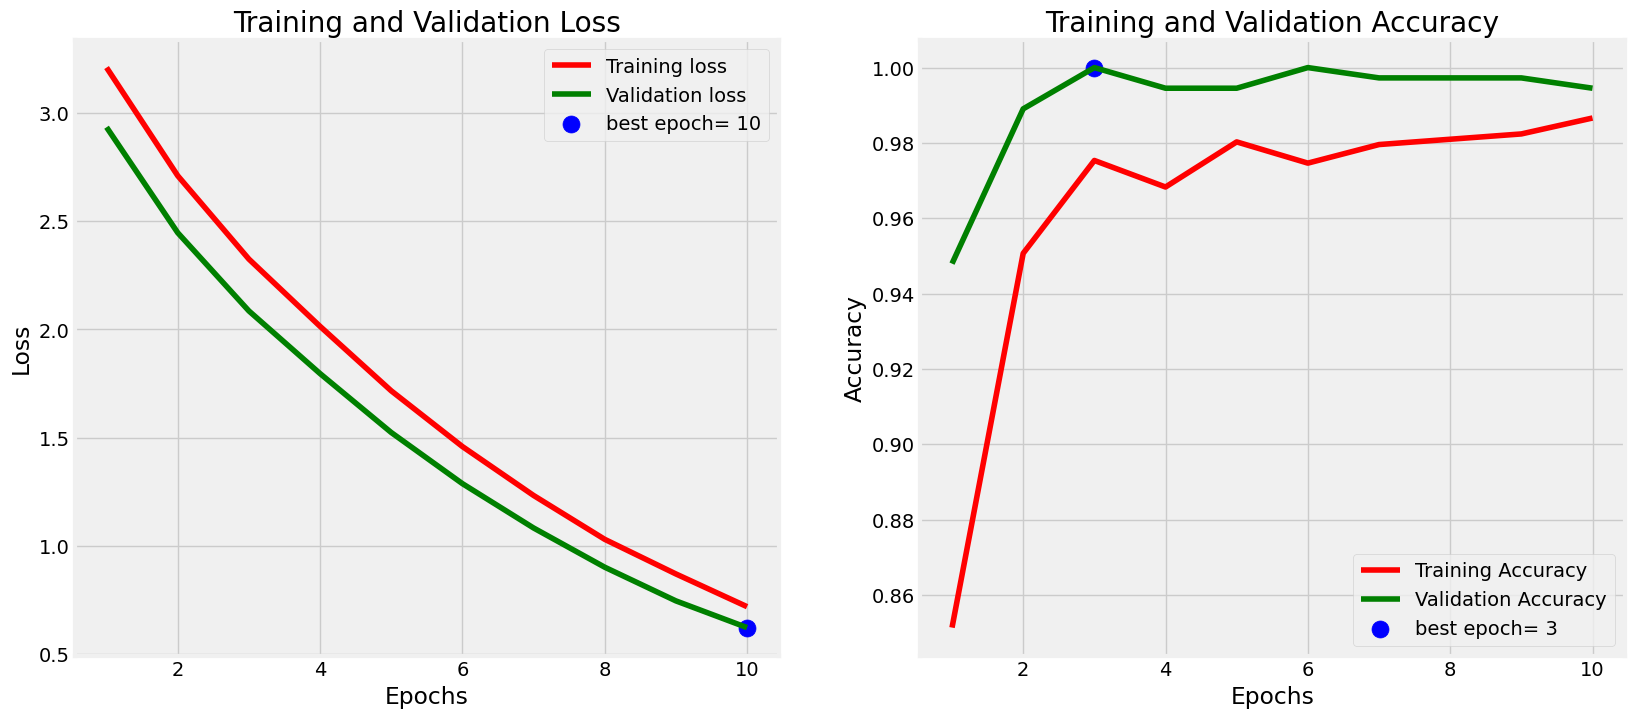

In [21]:
plot_training_history(history_type)

In [22]:
def evaluate_model(model, test_df, train_gen, valid_gen, test_gen):
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
    valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
    test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

    print('Train Loss: ', train_score[0])
    print('Train Accuracy: ', train_score[1])
    print('-' * 20)
    print('Test Loss: ', test_score[0])
    print('Test Accuracy: ', test_score[1])

In [23]:
evaluate_model(model_type, test_df_type, train_gen_type, valid_gen_type, test_gen_type)

4/4 [==============================] - 3s 672ms/step - loss: 0.6161 - accuracy: 1.0000


/Users/jngelena/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


4/4 [==============================] - 10s 2s/step - loss: 0.6212 - accuracy: 0.9959
Train Loss:  0.6157896518707275
Train Accuracy:  1.0
--------------------
Test Loss:  0.6211884021759033
Test Accuracy:  0.9959016442298889


In [24]:
preds_type = model_type.predict(test_gen_type)
y_pred_type = np.argmax(preds_type, axis=1)

4/4 [==============================] - 11s 2s/step


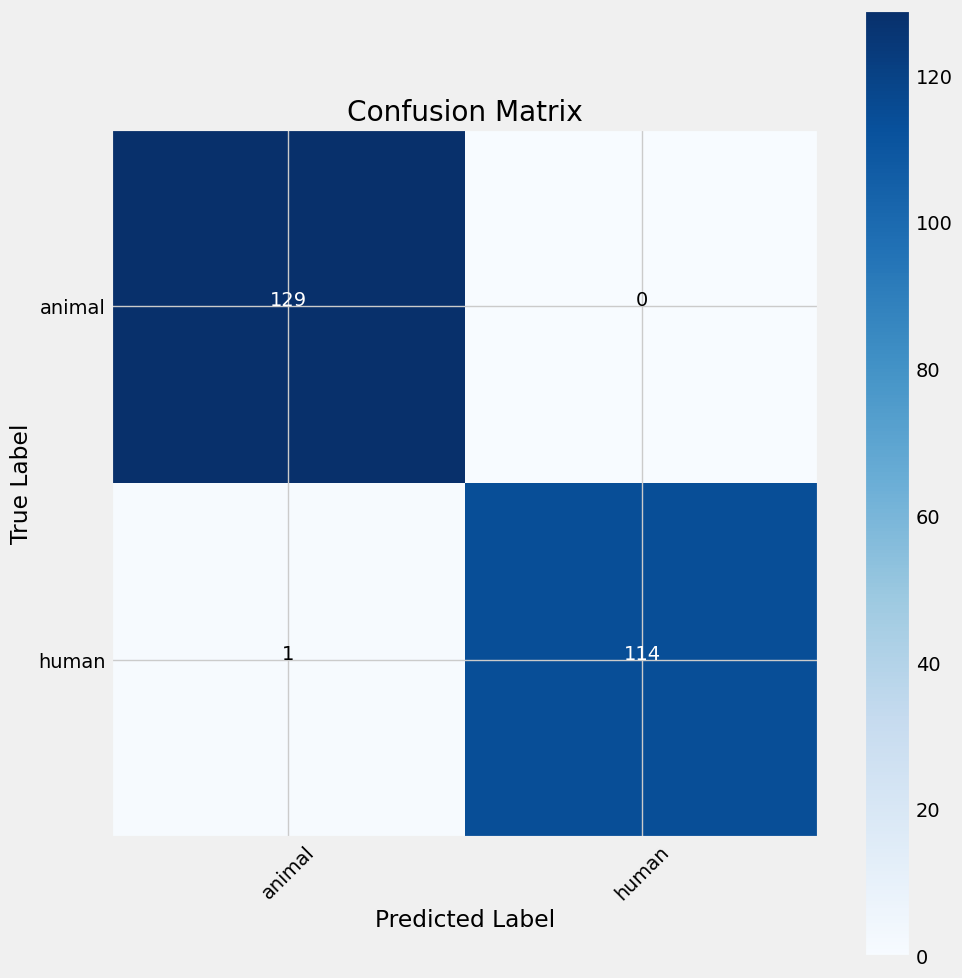

In [25]:
g_dict = test_gen_type.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen_type.classes, y_pred_type)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [26]:
# Classification report
print(classification_report(test_gen_type.classes, y_pred_type, target_names= classes))

              precision    recall  f1-score   support

      animal       0.99      1.00      1.00       129
       human       1.00      0.99      1.00       115

    accuracy                           1.00       244
   macro avg       1.00      1.00      1.00       244
weighted avg       1.00      1.00      1.00       244



In [60]:
model_type.save('Animal_Human_model.h5')

/Users/jngelena/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **1. Emotion**

In [28]:
image_path_label = generate_data_paths(emo_data_dir)
df_emotion = pd.DataFrame(list(image_path_label.items()), columns=['path', 'label'])
display(df_emotion)

,path,label
0,/Users/jngelena/Desktop/computer_vision/projec...,Happy
1,/Users/jngelena/Desktop/computer_vision/projec...,Happy
2,/Users/jngelena/Desktop/computer_vision/projec...,Happy
3,/Users/jngelena/Desktop/computer_vision/projec...,Happy
4,/Users/jngelena/Desktop/computer_vision/projec...,Happy
...,...,...
995,/Users/jngelena/Desktop/computer_vision/projec...,Angry
996,/Users/jngelena/Desktop/computer_vision/projec...,Angry
997,/Users/jngelena/Desktop/computer_vision/projec...,Angry
998,/Users/jngelena/Desktop/computer_vision/projec...,Angry


In [29]:
print(f"The Animal emotion dataset has {df_emotion.shape[0]} images divided in {len(df_emotion['label'].unique())} classes")

The Animal emotion dataset has 1000 images divided in 4 classes


In [30]:
classes_count(df_emotion, name='Animal emotion')

The Animal emotion has: 
Class 'Happy' has 250 images
Class 'Sad' has 250 images
Class 'Other' has 250 images
Class 'Angry' has 250 images


In [31]:
train_df_emo, valid_df_emo, test_df_emo = split_dataframe(df_emotion)

In [32]:
num_of_examples(train_df_emo, 'Animal emotion Training')
num_of_examples(valid_df_emo, 'Animal emotion Validation')
num_of_examples(test_df_emo, 'Animal emotion Testing')

The Animal emotion Training dataset has 700 images.
The Animal emotion Validation dataset has 180 images.
The Animal emotion Testing dataset has 120 images.


In [33]:
classes_count(train_df_emo, 'training dataset')

The training dataset has: 
Class 'Other' has 175 images
Class 'Sad' has 172 images
Class 'Angry' has 175 images
Class 'Happy' has 178 images


Found 700 validated image filenames belonging to 4 classes.
Found 180 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Training Generator:


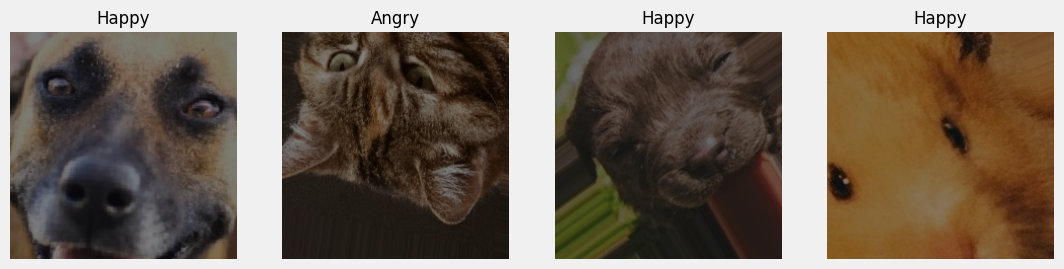

Validation Generator:


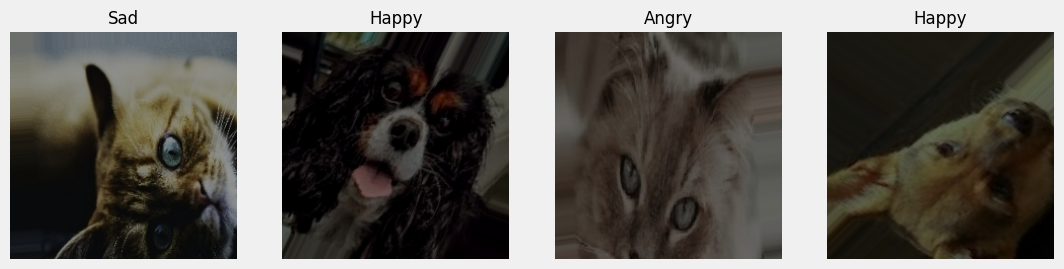

Test Generator:


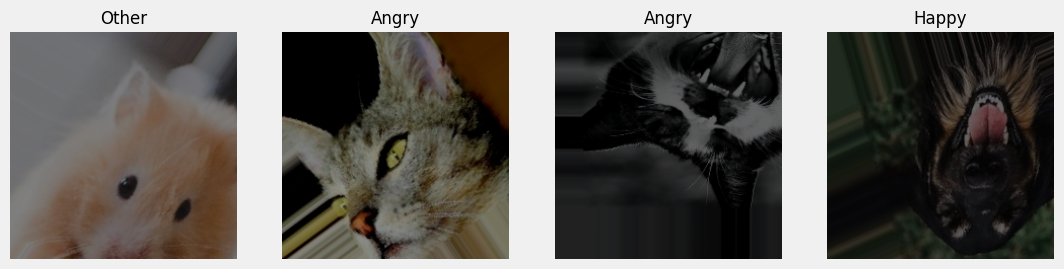

In [34]:
train_gen_emo, valid_gen_emo, test_gen_emo = create_and_plot_data_generators(train_df_emo, valid_df_emo, test_df_emo)

In [35]:
class_count_type = len(list(train_gen_emo.class_indices.keys()))
model_emo = create_efficientnet_model(class_count=class_count_type)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                

In [36]:
batch_size = 16   # set batch size for training
history_emo = model_emo.fit(x=train_gen_emo,
                    epochs= 100,
                    verbose= 1,
                    validation_data= valid_gen_emo, 
                    validation_steps= None,
                    shuffle= False)

Epoch 1/100
44/44 [==============================] - 38s 742ms/step - loss: 4.6634 - accuracy: 0.2829 - val_loss: 4.7476 - val_accuracy: 0.4000
Epoch 2/100
44/44 [==============================] - 31s 702ms/step - loss: 4.3394 - accuracy: 0.3800 - val_loss: 4.1923 - val_accuracy: 0.4278
Epoch 3/100
44/44 [==============================] - 32s 718ms/step - loss: 4.0770 - accuracy: 0.4543 - val_loss: 3.9381 - val_accuracy: 0.4556
Epoch 4/100
44/44 [==============================] - 32s 721ms/step - loss: 3.9324 - accuracy: 0.4829 - val_loss: 3.7741 - val_accuracy: 0.5444
Epoch 5/100
44/44 [==============================] - 32s 722ms/step - loss: 3.8216 - accuracy: 0.5071 - val_loss: 3.7102 - val_accuracy: 0.5444
Epoch 6/100
44/44 [==============================] - 32s 723ms/step - loss: 3.7178 - accuracy: 0.5286 - val_loss: 3.5624 - val_accuracy: 0.6000
Epoch 7/100
44/44 [==============================] - 32s 729ms/step - loss: 3.6303 - accuracy: 0.5229 - val_loss: 3.4911 - val_accuracy:

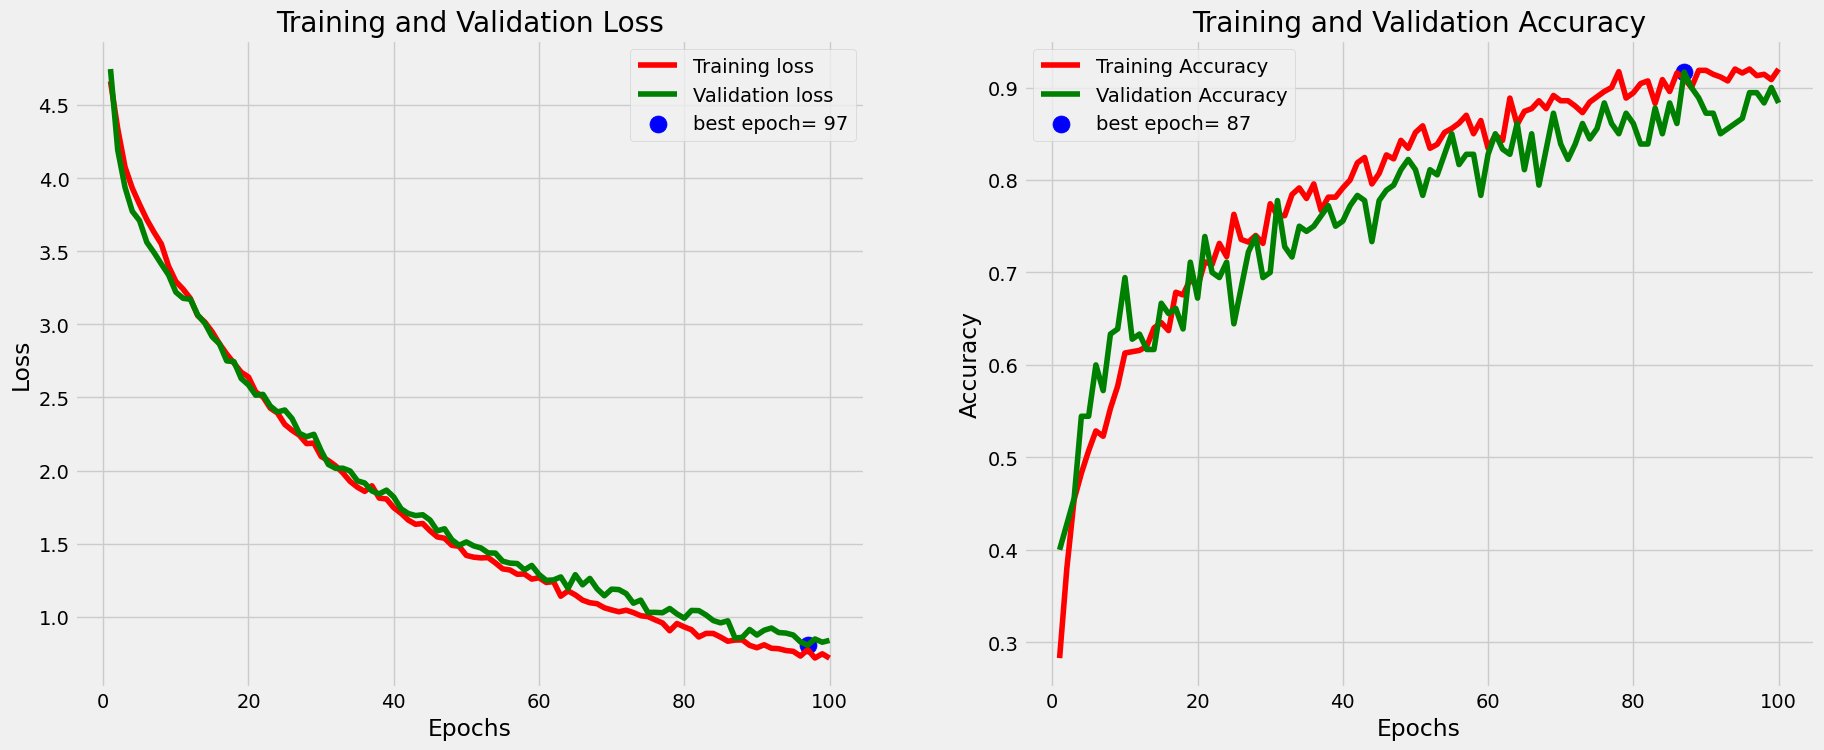

In [37]:
plot_training_history(history_emo)

In [38]:
evaluate_model(model_emo, test_df_emo, train_gen_emo, valid_gen_emo, test_gen_emo)

2/2 [==============================] - 4s 2s/step - loss: 0.7742 - accuracy: 0.8750
Train Loss:  0.5319703817367554
Train Accuracy:  1.0
--------------------
Test Loss:  0.7742112278938293
Test Accuracy:  0.875


In [39]:
preds_emo = model_emo.predict(test_gen_emo)
y_pred_emo = np.argmax(preds_emo, axis=1)

2/2 [==============================] - 6s 2s/step


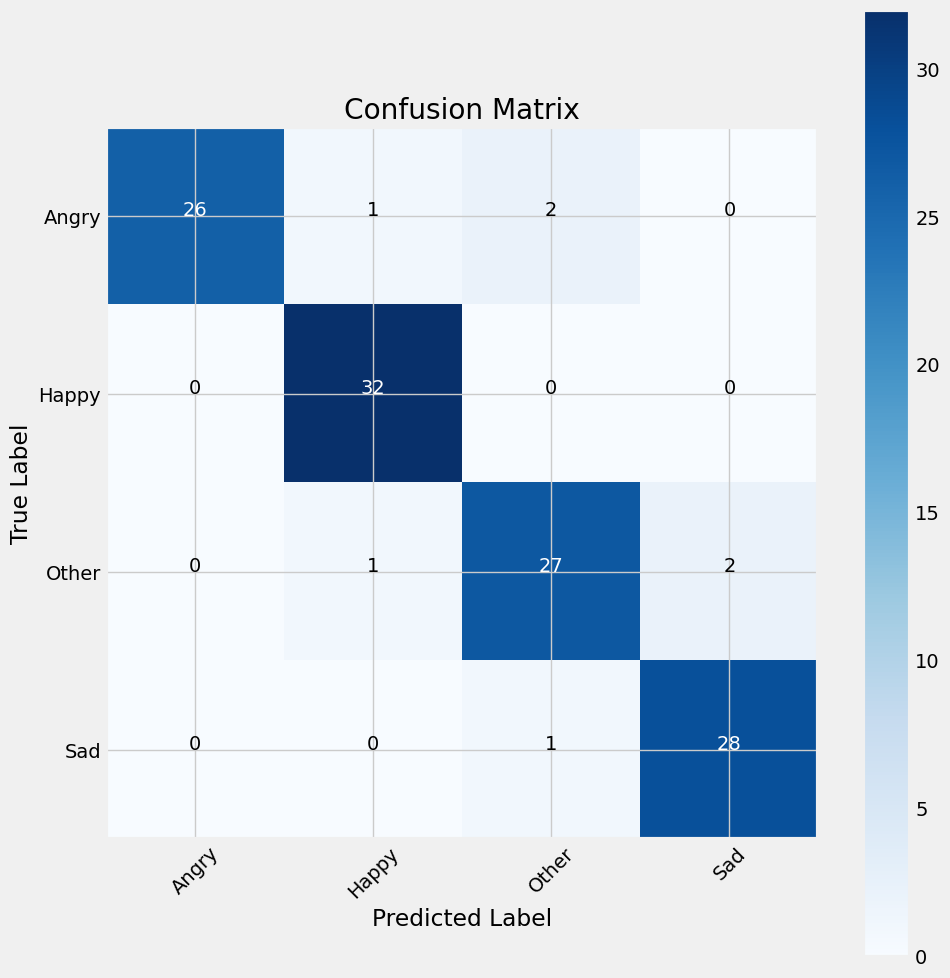

In [43]:
g_dict = test_gen_emo.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen_emo.classes, y_pred_emo)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [44]:
print(classification_report(test_gen_emo.classes, y_pred_emo, target_names= classes))

              precision    recall  f1-score   support

       Angry       1.00      0.90      0.95        29
       Happy       0.94      1.00      0.97        32
       Other       0.90      0.90      0.90        30
         Sad       0.93      0.97      0.95        29

    accuracy                           0.94       120
   macro avg       0.94      0.94      0.94       120
weighted avg       0.94      0.94      0.94       120



In [61]:
model_emo.save('Animal_emotion_model.h5')

1/1 [==============================] - 1s 1s/step


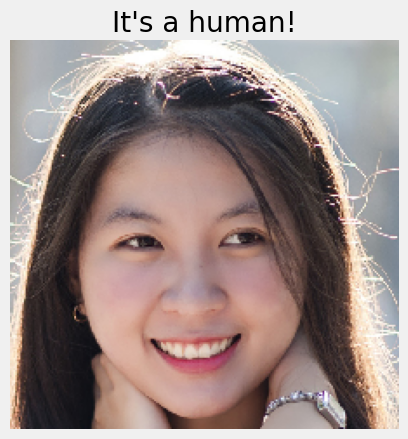

1/1 [==============================] - 1s 1s/step


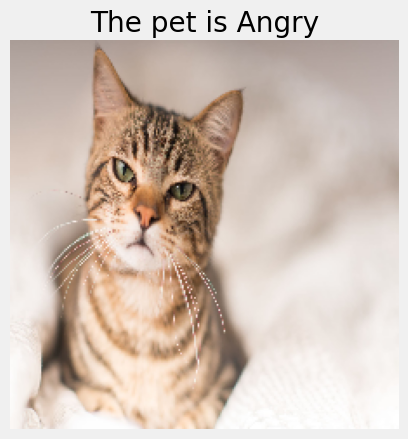

In [65]:
def predict_pet_or_human(image_path, pet_model, emotion_model):
    # Load the image and preprocess it
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Use Animal_Human_model to predict whether it's a pet or human
    pet_prediction = pet_model.predict(img_array)
    is_pet = pet_prediction[0][0] > 0.5  # Adjust the threshold as needed

    if is_pet:
        # If it's a pet, use Pets_Facial_Expression_model to predict emotion
        emotion_prediction = emotion_model.predict(img_array)
        emotion_class_index = np.argmax(emotion_prediction)
        class_labels = ['Angry', 'Other', 'Sad', 'Happy']
        emotion_label = class_labels[emotion_class_index]

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"The pet is {emotion_label}")
        plt.show()
    else:
        # If it's a human, you can add your logic here
        plt.imshow(img)
        plt.axis('off')
        plt.title("It's a human!")
        plt.show()

# Load Animal_Human_model and Pets_Facial_Expression_model
animal_human_model = load_model('Animal_Human_model.h5')
pets_emotion_model = load_model('Animal_emotion_model.h5')

# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = 'human1.jpg'
predict_pet_or_human(image_path_to_test, animal_human_model, pets_emotion_model)

image_path_to_test2 = 'animal.png'
predict_pet_or_human(image_path_to_test2, animal_human_model, pets_emotion_model)